## 🧠 Introduction

Classical algorithms are already incredibly effective at solving many optimization problems — especially when the number of variables is in the low thousands. However, when scaling up to problems involving **tens or hundreds of thousands** of binary variables, classical solvers begin to falter due to the **combinatorial explosion** in the search space.

Quantum computing offers a compelling alternative — not by brute force, but by **exploring exponentially large solution spaces in parallel** using quantum superposition and entanglement. One popular quantum algorithm for such problems is the **Quantum Approximate Optimization Algorithm (QAOA)** <sup>[3]</sup>, a textbook example of a variational quantum algorithm (VQA). However, QAOA requires **one qubit per binary variable**, which becomes **prohibitively resource-intensive** for large-scale problems.

For instance, solving a QUBO (Quadratic Unconstrained Binary Optimization) problem with 10,000 variables using QAOA would require 10,000 logical qubits — a scale **far beyond current quantum hardware capabilities**.

## 🔍 Why Qubit-Efficient Methods?

This demo explores **qubit-efficient alternatives** to QAOA that are not only suitable for today's NISQ (Noisy Intermediate-Scale Quantum) devices, but also **generalizable across combinatorial optimization problems**.

We specifically demonstrate these methods in the context of **unsupervised image segmentation**, by:

1. Formulating segmentation as a **min-cut problem** over a graph derived from the image.
2. Reformulating the min-cut as a **QUBO problem**.
3. Solving the QUBO using **qubit-efficient VQAs**, namely <sup>[1]</sup>:
   - **Parametric Gate Encoding (PGE)**
   - **Ancilla Basis Encoding (ABE)**
   - **Adaptive Cost Encoding (ACE)**

These methods only require a **logarithmic number of qubits** with respect to the problem size (i.e., number of binary variables). This makes them **scalable and implementable** even on near-term quantum hardware. Moreover, the exact graph-based image segmentation technique have been explored also using quantum annealers <sup>[2]</sup>.

While this demo walks through an image segmentation example, the encoding schemes presented here can be applied to **any binary combinatorial optimization problem**.


<figure>
  <img src="vqa-segmentation.png" alt="VQA Segmentation Overview" width="600">
  <figcaption>
    Architecture for segmenting an image by transforming it into a graph and solving the corresponding minimum cut as a QUBO problem using variational quantum circuits <sup>[1]</sup>.</a>
  </figcaption>
</figure>

---

## 🧱 Import dependencies

We begin by importing the standard Python libraries for graph construction and visualization, and PennyLane modules for quantum circuit construction and simulation. This setup ensures a seamless interface for hybrid quantum-classical processing.


In [1]:
import numpy as np
import networkx as nx
import pennylane as qml
from scipy.optimize import minimize, differential_evolution
import matplotlib.pyplot as plt

from math import ceil, log2
import time

## 🖼️ Generate an Example Image

To keep things intuitive, we generate a toy grayscale image. This synthetic image will be segmented using quantum algorithms.

We use a simple 4×4 grid for clarity. The pixel intensities will act as a proxy for similarity when we later construct a graph. Each pixel becomes a vertex, and edges represent similarity (e.g., inverse of intensity difference).


(np.float64(-0.5), np.float64(3.5), np.float64(3.5), np.float64(-0.5))

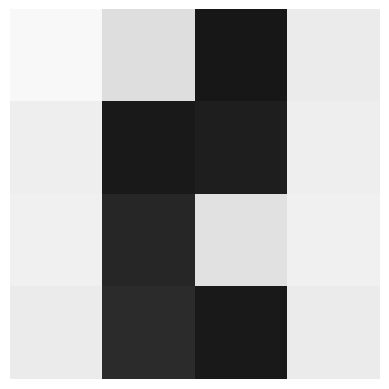

In [2]:
height,width = 4,4
image = np.array([
       [0.97,  0.87, 0.09, 0.92],
       [0.93,  0.10, 0.12, 0.93],
       [0.94,  0.15, 0.88, 0.94],
       [0.92,  0.17, 0.10, 0.92]
       ])


plt.imshow(image, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=1)
plt.axis('off')

## 🔗 Representing Image as a Graph

Each image is modeled as an undirected weighted grid graph:  
- Each pixel becomes a node.
- An edge exists between neighboring pixels.
- The weight reflects similarity (e.g., inverse absolute difference in grayscale values).

This transforms the segmentation task into a **minimum cut problem**, where the goal is to partition the graph to minimize the sum of cut edge weights.


In [3]:
def image_to_grid_graph(gray_img, sigma=0.5):
  # Convert image to grayscale
  # gray_img = np.dot(img, [0.2989, 0.5870, 0.1140])
  h, w = gray_img.shape
  # Initialize graph nodes and edges
  nodes = np.zeros((h*w, 1))
  edges = []
  nx_elist = []
  # Compute node potentials and edge weights
  min_weight = 1
  max_weight = 0
  for i in range(h*w):
    x, y = i//w, i%w
    nodes[i] = gray_img[x,y]
    if x > 0:
      j = (x-1)*w + y
      # weight = np.exp(-dist.euclidean([gray_img[x,y]], [gray_img[x-1,y]])**2 / (2*sigma**2))
      weight = 1-np.exp(-((gray_img[x,y] - gray_img[x-1,y])**2) / (2 * sigma**2))
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x-1,y),np.round(weight,2)))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
    if y > 0:
      j = x*w + y-1
      # weight = np.exp(-dist.euclidean([gray_img[x,y]], [gray_img[x,y-1]])**2 / (2*sigma**2))
      weight = 1-np.exp(-((gray_img[x,y] - gray_img[x,y-1])**2) / (2 * sigma**2))
      # print('weight',weight)
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x,y-1),np.round(weight,2)))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
  a=-1
  b=1
  if max_weight-min_weight:
    normalized_edges = [(node1,node2,-1*np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,2)) for node1,node2,edge_weight in edges]
    normalized_nx_elist = [(node1,node2,-1*np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,2)) for node1,node2,edge_weight in nx_elist]
  else:
    normalized_edges = [(node1,node2,-1*np.round(edge_weight,2)) for node1,node2,edge_weight in edges]
    normalized_nx_elist = [(node1,node2,-1*np.round(edge_weight,2)) for node1,node2,edge_weight in nx_elist]
  return nodes, edges, nx_elist, normalized_edges, normalized_nx_elist

pixel_values, elist, nx_elist, normalized_elist, normalized_nx_elist = image_to_grid_graph(image)



pixel_values, elist, nx_elist, normalized_elist, normalized_nx_elist

(array([[0.97],
        [0.87],
        [0.09],
        [0.92],
        [0.93],
        [0.1 ],
        [0.12],
        [0.93],
        [0.94],
        [0.15],
        [0.88],
        [0.94],
        [0.92],
        [0.17],
        [0.1 ],
        [0.92]]),
 [(1, 0, np.float64(0.019801326693244636)),
  (2, 1, np.float64(0.7038235833497333)),
  (3, 2, np.float64(0.7478673648566999)),
  (4, 0, np.float64(0.0031948854569670004)),
  (5, 1, np.float64(0.6944983196321949)),
  (5, 4, np.float64(0.7478673648566999)),
  (6, 2, np.float64(0.0017983809715627075)),
  (6, 5, np.float64(0.0007996800853162789)),
  (7, 3, np.float64(0.00019998000133325533)),
  (7, 6, np.float64(0.7307728952534005)),
  (8, 4, np.float64(0.00019998000133325533)),
  (9, 5, np.float64(0.00498752080731768)),
  (9, 8, np.float64(0.7129790300890826)),
  (10, 6, np.float64(0.6850054683032367)),
  (10, 9, np.float64(0.6555478172330909)),
  (11, 7, np.float64(0.00019998000133325533)),
  (11, 10, np.float64(0.007174142096186609)

In [4]:
G = nx.grid_2d_graph(image.shape[0], image.shape[1])
G.add_weighted_edges_from(normalized_nx_elist)

Pos: {(0, 0): (0, 0), (0, 1): (1, 0), (0, 2): (2, 0), (0, 3): (3, 0), (1, 0): (0, -1), (1, 1): (1, -1), (1, 2): (2, -1), (1, 3): (3, -1), (2, 0): (0, -2), (2, 1): (1, -2), (2, 2): (2, -2), (2, 3): (3, -2), (3, 0): (0, -3), (3, 1): (1, -3), (3, 2): (2, -3), (3, 3): (3, -3)}
{((0, 0), (1, 0)): np.float64(1.0), ((0, 0), (0, 1)): np.float64(0.95), ((0, 1), (1, 1)): np.float64(-0.85), ((0, 1), (0, 2)): np.float64(-0.87), ((0, 2), (1, 2)): np.float64(1.0), ((0, 2), (0, 3)): np.float64(-1.01), ((0, 3), (1, 3)): np.float64(1.0), ((1, 0), (2, 0)): np.float64(1.0), ((1, 0), (1, 1)): np.float64(-1.01), ((1, 1), (2, 1)): np.float64(1.0), ((1, 1), (1, 2)): np.float64(1.0), ((1, 2), (2, 2)): np.float64(-0.85), ((1, 2), (1, 3)): np.float64(-0.95), ((1, 3), (2, 3)): np.float64(1.0), ((2, 0), (3, 0)): np.float64(1.0), ((2, 0), (2, 1)): np.float64(-0.9), ((2, 1), (3, 1)): np.float64(1.0), ((2, 1), (2, 2)): np.float64(-0.76), ((2, 2), (3, 2)): np.float64(-0.87), ((2, 2), (2, 3)): np.float64(0.97), ((2, 3

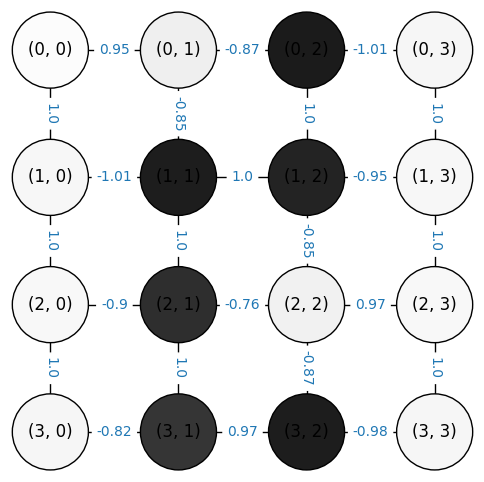

In [5]:
def draw(G):
  plt.figure(figsize=(6,6))
  default_axes = plt.axes(frameon=True)
  pos = {(x,y):(y,-x) for x,y in G.nodes()}
  print("Pos:",pos)
  nx.draw_networkx(G, pos)
  nodes = nx.draw_networkx_nodes(G, pos, node_color=1-pixel_values,
                  node_size=3000,
                  cmap=plt.cm.Greys, vmin=0, vmax=1)
  nodes.set_edgecolor('k')
  edge_labels = nx.get_edge_attributes(G, "weight")
  print(edge_labels)
  nx.draw_networkx_edge_labels(G,
                              pos=pos,
                              edge_labels=edge_labels,
                              font_size=10,
                              font_color='tab:blue')
  plt.axis('off')
#   plt.savefig("2x2_graph.jpg", dpi=600, bbox_inches='tight', pad_inches=0)
draw(G)

## 🔁 Parametric Gate Encoding (PGE)

In PGE, we directly encode the binary segmentation mask in the rotation parameters of a diagonal gate <sup>[4]</sup>.

Only $\log_2(n)$ qubits are required, which is a **huge gain** over methods like QAOA that need $O(n)$.

### Quantum Circuit:
- Apply Hadamard gates to initialize a uniform superposition.
- Apply a diagonal gate $U(\vec{\theta})$ whose entries encode binary values using a thresholding function $f(\theta_i)$.
- Evaluate the cost function:
$$
C(\vec{\theta}) = \langle \psi(\vec{\theta}) | L_G | \psi(\vec{\theta}) \rangle
$$
where $L_G$ is the graph Laplacian.

The result is optimized using a classical optimizer, and $\theta_i$ are mapped to bits depending on whether $\theta_i < \pi$ or not.


In [6]:
n = G.number_of_nodes()
n_qubits = int(np.ceil(np.log2(n)))
n_qubits

4

In [7]:
def R(theta): 
    if abs(theta) > 2*np.pi or abs(theta) < 0:
        theta = abs(theta) - (np.floor(abs(theta)/(2*np.pi))*(2*np.pi))
    return 0 if 0 <= theta < np.pi else 1

# Define a PennyLane quantum device (using default.qubit simulator)
dev = qml.device("default.qubit", wires=n_qubits)

In [8]:
# Quantum circuit as a QNode
@qml.qnode(dev)
def circuit(params, H):
    # N = len(params)
    N = int(np.log2(len(params)))
    for i in range(N):
        qml.Hadamard(wires=i)
    
    diagonal_elements = [np.exp(1j * np.pi * R(param)) for param in params]
    # qml.DiagonalQubitUnitary(np.diag(diagonal_elements), wires=list(range(N)))
    qml.DiagonalQubitUnitary(diagonal_elements, wires=list(range(N)))
    
    return qml.expval(qml.Hermitian(H, wires=list(range(N))))

In [9]:
def cost_fn(params, H):
    global optimization_iteration_count
    optimization_iteration_count += 1
    cost = circuit(params, H)
    print(f'@ Iteration {optimization_iteration_count} Cost :', cost)
    return cost

In [10]:
def decode(optimal_params):
    return [R(param) for param in optimal_params]

def objective_value(x, w):
    return np.dot(x, np.dot(w, x))

In [24]:
def new_nisq_algo_solver(G, optimizer_method='Powell', initial_params_seed=123):
    global optimization_iteration_count
    optimization_iteration_count = 0
    n = G.number_of_nodes()
    w = nx.adjacency_matrix(G).todense()
    D_G = np.diag(list(dict(G.degree()).values()))
    A_G = w
    L_G = D_G - A_G
    n_padding = (2**int(np.ceil(np.log2(n)))-n)
    L_G = np.pad(L_G, [(0, n_padding), (0, n_padding) ], mode='constant')
    H = L_G
    
    np.random.seed(seed=initial_params_seed)
    initial_params = np.random.uniform(low=0.5, high=2*np.pi , size=(n+n_padding))
    
    result = minimize(
        fun=cost_fn,
        x0=initial_params,
        args=(H,),
        method=optimizer_method,
    )
    
    optimal_params, expectation_value = result.x, result.fun
    x = np.real(decode(optimal_params))
    x = x[:n]
    cut_value = objective_value(x, w)
    
    return x, expectation_value, cut_value

In [25]:
binary_solution, expectation_value, cut_value = new_nisq_algo_solver(G, optimizer_method = 'Powell')
binary_solution, expectation_value, cut_value

@ Iteration 1 Cost : 2.6649999999999983
@ Iteration 2 Cost : 2.6649999999999983
@ Iteration 3 Cost : 2.6649999999999983
@ Iteration 4 Cost : 2.6774999999999984
@ Iteration 5 Cost : 2.6649999999999983
@ Iteration 6 Cost : 2.6774999999999984
@ Iteration 7 Cost : 2.6649999999999983
@ Iteration 8 Cost : 2.6649999999999983
@ Iteration 9 Cost : 2.6649999999999983
@ Iteration 10 Cost : 2.6649999999999983
@ Iteration 11 Cost : 2.6649999999999983
@ Iteration 12 Cost : 2.6649999999999983
@ Iteration 13 Cost : 2.6649999999999983
@ Iteration 14 Cost : 2.6649999999999983
@ Iteration 15 Cost : 1.9974999999999987
@ Iteration 16 Cost : 1.9974999999999987
@ Iteration 17 Cost : 1.9974999999999987
@ Iteration 18 Cost : 1.9974999999999987
@ Iteration 19 Cost : 1.9974999999999987
@ Iteration 20 Cost : 1.9974999999999987
@ Iteration 21 Cost : 1.9974999999999987
@ Iteration 22 Cost : 1.9974999999999987
@ Iteration 23 Cost : 1.9974999999999987
@ Iteration 24 Cost : 1.9974999999999987
@ Iteration 25 Cost : 1.9

(array([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]),
 np.float64(0.155),
 np.float64(-9.870000000000001))

In [26]:
def decode_binary_string(x, height, width):
  mask = np.zeros([height, width])
  for index,segment in enumerate(x):
    mask[index//width,index%width]=segment
  return mask

(np.float64(-0.5), np.float64(3.5), np.float64(3.5), np.float64(-0.5))

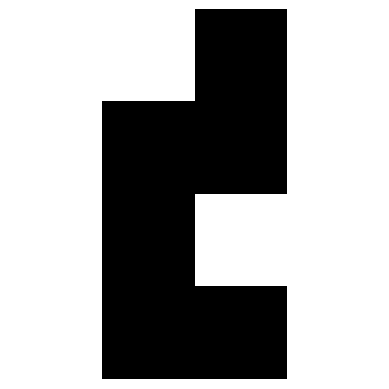

In [27]:
mask = decode_binary_string(x, height, width)
plt.imshow(mask, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=1)
plt.axis('off')


## 🧪 Ancilla Basis Encoding (ABE)

ABE uses $\log_2(n) + 1$ qubits:  
- $\log_2(n)$ **register qubits** represent binary states.  
- One **ancilla qubit** helps encode the binary decision.

Each computational basis state of the register corresponds to one binary variable. The ancilla qubit’s amplitude is used to decide the bit value <sup>[5]</sup>:
$$
x_{v_i} = \begin{cases} 0 & \text{if } |a_i|^2 > |b_i|^2 \\ 1 & \text{otherwise} \end{cases}
$$

The cost function is parameterized over **expectation values** of basis state projectors:
$$
C(\vec{\theta}) = \sum_{i,j} Q_{ij} \frac{\langle \hat{P}_i^1 \rangle \langle \hat{P}_j^1 \rangle}{\langle \hat{P}_i \rangle \langle \hat{P}_j \rangle} (1 - \delta_{ij}) + \sum_i Q_{ii} \frac{\langle \hat{P}_i^1 \rangle}{\langle \hat{P}_i \rangle}
$$

<figure>
  <img src="ABE_ACE.png" alt="Quantum Circuit of ABE/ACE" width="1080">
  <figcaption>Quantum circuit of ABE/ACE for solving QUBO of size 4 using 3 qubits (2 register + 1 ancilla). Basis state amplitudes are used to decode the binary solution <sup>[1]</sup>.</figcaption>
</figure>

In [15]:
def get_qubo_matrix(W):
    """Computes the QUBO matrix for the Minimum Cut problem given a weight matrix W."""
    n = W.shape[0]  # Number of nodes
    Q = np.zeros((n, n))  # Initialize QUBO matrix
    
    for i in range(n):
        Q[i, i] = np.sum(W[i])  # Diagonal terms (degree of node)
        for j in range(n):
            if i != j:
                Q[i, j] = -W[i, j]  # Off-diagonal terms (negative adjacency)
    
    return Q

In [16]:
def get_circuit(nq, n_layers):
    def circuit(params):
        for i in range(nq):
            qml.Hadamard(wires=i)
        for layer_i in range(n_layers):
            for qubit_i in range(nq - 1):
                qml.CNOT(wires=[qubit_i, (qubit_i + 1) % nq])
            for qubit_i in range(nq):
                qml.RY(params[(nq * layer_i) + qubit_i], wires=qubit_i)
        return qml.probs(wires=range(nq))
    return circuit

def get_projectors(probabilities, n_c):
    P, P1 = [0] * n_c, [0] * n_c
    for k, v in probabilities.items():
        index = int(k[1:], 2)
        P[index] += v
        if k[0] == '1':
            P1[index] += v
    return P, P1

def objective_value(x, w):
    return sum(w[i, j] * x[i] * (1 - x[j]) for i in range(len(x)) for j in range(len(x)))

def decode_probabilities(probabilities):
    binary_solution, n_r = [], len(list(probabilities.keys())[0]) - 1
    for i in range(2**n_r):
        zero_state, one_state = '0' + format(i, 'b').zfill(n_r), '1' + format(i, 'b').zfill(n_r)
        if zero_state in probabilities and one_state in probabilities:
            binary_solution.append(0 if probabilities[zero_state] > probabilities[one_state] else 1)
        elif zero_state in probabilities:
            binary_solution.append(0)
        elif one_state in probabilities:
            binary_solution.append(1)
    return binary_solution

In [17]:
def evaluate_cost(params, circuit, qubo_matrix):
    global valid_probabilities, optimization_iteration_count, best_cost, best_params
    optimization_iteration_count += 1
    raw_probs = circuit(params)  # NumPy array

    # Convert probability array to dictionary with bitstrings
    num_qubits = int(np.log2(len(raw_probs)))
    bitstrings = [format(i, f'0{num_qubits}b') for i in range(len(raw_probs))]
    probabilities = {bitstrings[i]: raw_probs[i] for i in range(len(raw_probs))}
    
    n_c = 2**(len(bitstrings[0])-1)
    P, P1 = get_projectors(probabilities, n_c)
    if 0 in P:
        return float("inf")

    valid_probabilities = probabilities.copy()
    cost = sum(qubo_matrix[i][j] * P1[i] / P[i] if i == j else (qubo_matrix[i][j] * P1[i] * P1[j]) / (P[i] * P[j])
               for i in range(len(qubo_matrix)) for j in range(len(qubo_matrix)))
    
    # Track the best cost and parameters manually
    if cost < best_cost:
        best_cost = cost
        best_params = params.copy()  # Store the best parameter set
    
    print(f'@ Iteration {optimization_iteration_count} Cost :', cost)
    return cost

In [23]:
def ancilla_basis_encoding(G, initial_params, n_layers=1, optimizer_method='differential_evolution'):
    w = nx.adjacency_matrix(G).todense()
    Q = get_qubo_matrix(W = w)
    nc, nq = len(G.nodes()), ceil(log2(len(G.nodes()))) + 1
    dev = qml.device("default.qubit", wires=nq, shots=None)
    qnode = qml.QNode(get_circuit(nq, n_layers), dev)
    global valid_probabilities, optimization_iteration_count, best_cost, best_params  # Track the best parameters
    valid_probabilities, optimization_iteration_count = [], 0
    best_cost = float("inf")  # Initialize best cost
    best_params = None  # Initialize best parameters
    if optimizer_method == "differential_evolution":
        optimization_result = differential_evolution(
            func=evaluate_cost,
            bounds=[(-np.pi, np.pi)] * len(initial_params),
            args=(qnode, Q),
            strategy='best1bin',
            maxiter=100,
            popsize=10
        )
    else:
        optimization_result = minimize(fun=evaluate_cost, x0=initial_params, args=(qnode, Q), method=optimizer_method,
                                       bounds=[(-np.pi, np.pi)] * len(initial_params))
    if not valid_probabilities:
        return False, [0] * nc, 0, 0, [0] * len(initial_params)
    best_raw_probs = qnode(best_params)
    bitstrings = [format(i, f'0{nq}b') for i in range(len(best_raw_probs))]
    best_probabilities = {bitstrings[i]: best_raw_probs[i] for i in range(len(best_raw_probs))}
    binary_solution = decode_probabilities(best_probabilities)[:nc]
    print("binary_solution",binary_solution)
    return binary_solution, best_cost, objective_value(np.array(binary_solution), w), best_params

Although the code can handle various methods available in `scipy.minimize`, in this demo we will be using a more robust genetic algorithm `differential_evolution` as the classical optimizer.

Executing QC with 4 layers and differential_evolution optimizer.
@ Iteration 1 Cost : 1.882524746903473
@ Iteration 2 Cost : 1.3307136092619642
@ Iteration 3 Cost : -0.0024249293953636708
@ Iteration 4 Cost : 3.135772683858247
@ Iteration 5 Cost : 1.7455372963676026
@ Iteration 6 Cost : 2.979455968553353
@ Iteration 7 Cost : 0.7156952290785642
@ Iteration 8 Cost : 2.5690281878461834
@ Iteration 9 Cost : 1.490887210966192
@ Iteration 10 Cost : -0.36050426202109254
@ Iteration 11 Cost : -0.043592265367668186
@ Iteration 12 Cost : 1.3172971005009158
@ Iteration 13 Cost : 1.5993213590381237
@ Iteration 14 Cost : 0.7465160255164605
@ Iteration 15 Cost : 1.732471807323885
@ Iteration 16 Cost : 0.6160827622099003
@ Iteration 17 Cost : 1.6039374613875843
@ Iteration 18 Cost : 1.5652224091322493
@ Iteration 19 Cost : 1.1647546189102866
@ Iteration 20 Cost : 3.214765266501002
@ Iteration 21 Cost : 1.6509313710030116
@ Iteration 22 Cost : 1.014378465394994
@ Iteration 23 Cost : 1.1972874437470487

(np.float64(-0.5), np.float64(3.5), np.float64(3.5), np.float64(-0.5))

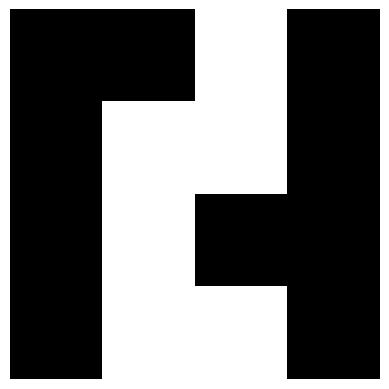

In [ ]:
initial_params_seed, scipy_optimizer_method, n_layers = 42, "differential_evolution", 4
nq = ceil(log2(len(G.nodes()))) + 1
np.random.seed(initial_params_seed)
initial_params = np.random.uniform(low=-np.pi, high=np.pi, size=nq * n_layers)
print(f"Executing QC with {n_layers} layers and {scipy_optimizer_method} optimizer.")
start_time = time.time()
solution, value, cut_value, optimal_params = ancilla_basis_encoding(G, initial_params, n_layers, scipy_optimizer_method)
end_time = time.time()
print(solution, value, cut_value, optimal_params)

mask = decode_binary_string(solution, height, width)
plt.imshow(mask, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=1)
plt.axis('off')

## 🔁 Adaptive Cost Encoding (ACE)

ACE modifies ABE by skipping the QUBO formulation entirely during evaluation.

Instead of optimizing over probabilities, we decode a binary vector $x$ from the measured output and evaluate the **original min-cut cost function** directly <sup>[1]</sup>:
$$
C(x) = \sum_{i < j} x_i (1 - x_j) w(v_i, v_j)
$$

This:
- Removes the need for a QUBO matrix, which can have loss of generality for constrained optimization problems when the penalty coefficient is not set appropriately.
- Improves convergence (the cost function is discrete and combinatorial).
- Aligns optimization directly with the true task objective.

In [20]:
def evaluate_cost_mincut(params, circuit, w):
    global valid_probabilities, optimization_iteration_count, best_cost, best_params
    optimization_iteration_count += 1
    raw_probs = circuit(params)  # NumPy array
    
    # Convert probability array to dictionary with bitstrings
    num_qubits = int(np.log2(len(raw_probs)))
    bitstrings = [format(i, f'0{num_qubits}b') for i in range(len(raw_probs))]
    probabilities = {bitstrings[i]: raw_probs[i] for i in range(len(raw_probs))}
    
    n_c = 2**(len(bitstrings[0])-1)
    P, P1 = get_projectors(probabilities, n_c)
    if 0 in P:
        return float("inf")
    valid_probabilities = probabilities.copy()
    binary_solution = decode_probabilities(valid_probabilities)[:len(w)]
    cost = objective_value(np.array(binary_solution), w)

    # Track the best cost and parameters manually
    if cost < best_cost:
        best_cost = cost
        best_params = params.copy()  # Store the best parameter set
    
    print(f'@ Iteration {optimization_iteration_count} Cost :', cost)
    return cost

In [ ]:
def adaptive_cost_encoding_de(G, initial_params, n_layers=1, optimizer_method='differential_evolution'):
    w = nx.adjacency_matrix(G).todense()
    nc, nq = len(G.nodes()), ceil(log2(len(G.nodes()))) + 1
    dev = qml.device("default.qubit", wires=nq, shots=None)
    qnode = qml.QNode(get_circuit(nq, n_layers), dev)
    global valid_probabilities, optimization_iteration_count, best_cost, best_params  # Track the best parameters
    valid_probabilities, optimization_iteration_count = [], 0
    best_cost = float("inf")  # Initialize best cost
    best_params = None  # Initialize best parameters

    if optimizer_method == "differential_evolution":
        optimization_result = differential_evolution(
            func=evaluate_cost_mincut,
            bounds=[(-np.pi, np.pi)] * len(initial_params),
            args=(qnode, w),
            strategy='best1bin',
            maxiter=100,
            popsize=10
        )
    else:
        optimization_result = minimize(fun=evaluate_cost_mincut, x0=initial_params, args=(qnode, w), method=optimizer_method,
                                       bounds=[(-np.pi, np.pi)] * len(initial_params))
    
    if not valid_probabilities:
        return False, [0] * nc, 0, 0, [0] * len(initial_params)
    
    best_raw_probs = qnode(best_params)
    bitstrings = [format(i, f'0{nq}b') for i in range(len(best_raw_probs))]
    best_probabilities = {bitstrings[i]: best_raw_probs[i] for i in range(len(best_raw_probs))}
    binary_solution = decode_probabilities(best_probabilities)[:nc]
    print("binary_solution",binary_solution)
    return binary_solution, best_cost, objective_value(np.array(binary_solution), w), best_params

Executing QC with 4 layers and Differential Evolution optimizer.
@ Iteration 1 Cost : 2.38
@ Iteration 2 Cost : 0.7300000000000004
@ Iteration 3 Cost : -1.4900000000000002
@ Iteration 4 Cost : 5.28
@ Iteration 5 Cost : 2.2
@ Iteration 6 Cost : 5.379999999999999
@ Iteration 7 Cost : -1.3300000000000005
@ Iteration 8 Cost : 4.2299999999999995
@ Iteration 9 Cost : 2.04
@ Iteration 10 Cost : 0.0
@ Iteration 11 Cost : -2.39
@ Iteration 12 Cost : 1.5799999999999996
@ Iteration 13 Cost : 2.99
@ Iteration 14 Cost : 2.43
@ Iteration 15 Cost : -1.4499999999999997
@ Iteration 16 Cost : 0.0
@ Iteration 17 Cost : -0.4700000000000001
@ Iteration 18 Cost : 1.37
@ Iteration 19 Cost : 2.15
@ Iteration 20 Cost : 4.1
@ Iteration 21 Cost : 1.3899999999999997
@ Iteration 22 Cost : 0.6400000000000003
@ Iteration 23 Cost : -0.7299999999999999
@ Iteration 24 Cost : -0.2999999999999997
@ Iteration 25 Cost : 1.37
@ Iteration 26 Cost : -0.6599999999999998
@ Iteration 27 Cost : 1.48
@ Iteration 28 Cost : 3.1
@ It

(np.float64(-0.5), np.float64(3.5), np.float64(3.5), np.float64(-0.5))

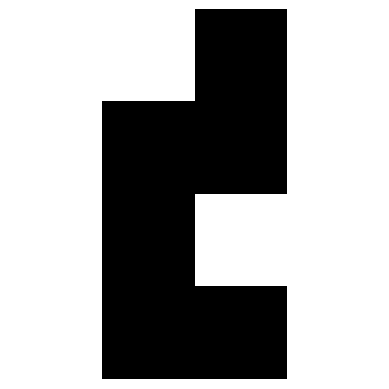

In [ ]:
initial_params_seed, scipy_optimizer_method, n_layers = 42, "differential_evolution", 4
nq = ceil(log2(len(G.nodes()))) + 1
np.random.seed(initial_params_seed)
initial_params = np.random.uniform(low=-np.pi, high=np.pi, size=nq * n_layers)
print(f"Executing QC with {n_layers} layers and Differential Evolution optimizer.")
start_time = time.time()
solution, value, cut_value, optimal_params = adaptive_cost_encoding_de(G, initial_params, n_layers, optimizer_method=scipy_optimizer_method)
end_time = time.time()
print(solution, value, cut_value, optimal_params)

mask = decode_binary_string(solution, height, width)
plt.imshow(mask, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=1)
plt.axis('off')

## 📈 Evaluation & Observations

- PGE has a compact circuit but many parameters.
- ABE introduces a more efficient encoding at the cost of probabilistic decoding.
- ACE improves convergence by using the real problem cost and avoiding indirect probability-based objectives.

Theoretical scaling advantages:
- Qubit requirement is $O(\log n)$.
- Parametric gates and depth grow modestly with problem size.


Here's the complexity comparison of QAOA, PGE, and ABE/ACE in terms of quantum resources for solving QUBO problems.

<table>
  <thead>
    <tr>
      <th>Method</th>
      <th>Qubit Complexity</th>
      <th>Entanglement Gates</th>
      <th>Parametric Gates</th>
      <th>Circuit Depth</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>QAOA</strong></td>
      <td>O(n)</td>
      <td>O(n²)</td>
      <td>O(L·n)</td>
      <td>O(L·n²)</td>
    </tr>
    <tr>
      <td><strong>PGE</strong></td>
      <td>log₂(n)</td>
      <td>n − 1</td>
      <td>n</td>
      <td>n</td>
    </tr>
    <tr>
      <td><strong>ABE / ACE</strong></td>
      <td>log₂(n) + 1</td>
      <td>L·log₂(n)</td>
      <td>L·(log₂(n) + 1)</td>
      <td>L·(log₂(n) + 1)</td>
    </tr>
  </tbody>
</table>
(L from the ansatz depth, n is the number of QUBO variables.)

## 📎 Final Notes


This demo showcases a scalable, qubit-efficient strategy for quantum-enhanced image segmentation.

By formulating image segmentation as a graph cut, reducing it to a QUBO, and then solving with advanced encodings like PGE, ABE, and ACE, we show that near-term quantum devices can tackle meaningful vision tasks.

---

## 📄 References

[1] S. M. Venkatesh, A. Macaluso, M. Nuske, M. Klusch, and A. Dengel, "Qubit-Efficient Variational Quantum Algorithms for Image Segmentation," 2024 IEEE International Conference on Quantum Computing and Engineering (QCE), Montreal, QC, Canada, 2024, pp. 450–456. DOI: [10.1109/QCE60285.2024.00059](https://doi.org/10.1109/QCE60285.2024.00059), [arXiv:2405.14405](https://arxiv.org/abs/2405.14405)

[2] S. M. Venkatesh, A. Macaluso, M. Nuske, M. Klusch and A. Dengel, "Q-Seg: Quantum Annealing-Based Unsupervised Image Segmentation," in IEEE Computer Graphics and Applications, vol. 44, no. 5, pp. 27-39, Sept.-Oct. 2024, doi: [10.1109/MCG.2024.3455012](https://doi.org/10.1109/MCG.2024.3455012), [arXiv:2311.12912](https://arxiv.org/abs/2311.12912).

[3] Farhi, E., Goldstone, J., & Gutmann, S. (2014). A quantum approximate optimization algorithm. arXiv preprint [arXiv:1411.4028](https://arxiv.org/abs/1411.4028).

[4] Rančić, M. J. (2023). Noisy intermediate-scale quantum computing algorithm for solving an n-vertex MaxCut problem with log (n) qubits. Physical Review Research, 5(1), L012021. DOI: [10.1103/PhysRevResearch.5.L012021](https://doi.org/10.1103/PhysRevResearch.5.L012021)

[5] Tan, B., Lemonde, M. A., Thanasilp, S., Tangpanitanon, J., & Angelakis, D. G. (2021). Qubit-efficient encoding schemes for binary optimisation problems. Quantum, 5, 454. DOI: [10.22331/q-2021-05-04-454](https://doi.org/10.22331/q-2021-05-04-454)